# Sawyer Jacobson
## HR Analytics for Data Scientists

In [1]:
import pandas as pd
import numpy as np
import sklearn
from plotnine import *
import plotnine
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import scipy
from sklearn import metrics
import sklearn as sk

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# training dataset that includes target variable
job_train = pd.read_csv('data/aug_train.csv')

# test dataset that does not have the target variable included
job_test = pd.read_csv('data/aug_test.csv')
job_test['target'] = np.load("data/jobchange_test_target_values.npy")

job_train.shape
job_test.shape

(19158, 14)

(2129, 14)

This data is from kaggle so prespecified train and test datasets were created so people could compare modeling results. For this project, I'm going to combine them and make my own train/test splits. The data is known to be somewhat unbalanced in the target variable so resampling methods may be used to balance the data.

In [3]:
from sklearn.model_selection import train_test_split
# combining the data to do our own train/test split
job = pd.concat([job_train, job_test], axis='index', ignore_index=True)

# peeking at the data columns
job.head()
# removing some useless columns
job.drop(columns = ['enrollee_id', 'city'], inplace=True)
# checking how much data we have
job.shape
# checking for missing values
job.isnull().sum()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


(21287, 12)

city_development_index       0
gender                    5016
relevent_experience          0
enrolled_university        417
education_level            512
major_discipline          3125
experience                  70
company_size              6560
company_type              6774
last_new_job               463
training_hours               0
target                       0
dtype: int64

We have quite a few missing values. Most of it is likely just randomly missing because the questions weren't answered.

# Variable Descriptions

- enrollee_id: Unique ID for candidate
- city: City code
- city_ development _index: Developement index of the city (scaled)
- gender: Gender of candidate
- relevent_experience: Relevant experience of candidate
- enrolled_university: Type of University course enrolled if any
- education_level: Education level of candidate
- major_discipline: Education major discipline of candidate
- experience: Candidate total experience in years
- company_size: No of employees in current employer's company
- company_type: Type of current employer
- last_new_job: Difference in years between previous job and current job
- training_hours: training hours completed
- target: 0 – Not looking for job change, 1 – Looking for a job change

We can tell from the variable descriptions above that many of these variables are categorical but ordinal which makes numeric encoding a good option. Use OneHotEncoding for the others.

In [4]:
# checking the distribution of the target variable
job['target'].value_counts()
y = job.pop('target')
# splitting data to only do EDA on the training data
X_train, X_test, y_train, y_test = train_test_split(job, y, test_size=0.25, random_state=42)

# creating a dataset with the training data and the target variable in for visualization
job_eda = X_train.copy()
job_eda['target'] = y_train.copy().astype(str)

# clean up some variables for better visualization
job_eda['enrolled_university'] = job_eda['enrolled_university'].replace("no_enrollment", "No enrollment")
job_eda['major_discipline'] = job_eda['major_discipline'].replace("Business Degree","Business")
job_eda['experience'] = job_eda['experience'].replace("<1", "0")
# job_eda['experience'] = job_eda['experience'].replace(">20", "21")
job_eda['company_size'] = job_eda['company_size'].replace("10/49", "10-49")
job_eda['target'] = job_eda['target'].replace("0.0", "Not looking")
job_eda['target'] = job_eda['target'].replace('1.0', "Looking")

print("X Train shape:", X_train.shape)
print("X Test shape:", X_test.shape)
print("y Train shape:", y_train.shape)
print("y Test shape:", y_test.shape)
X_train.head()
X_train.info()
y_train.head()

0.0    15934
1.0     5353
Name: target, dtype: int64

X Train shape: (15965, 11)
X Test shape: (5322, 11)
y Train shape: (15965,)
y Test shape: (5322,)


,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
18325,0.897,Male,Has relevent experience,no_enrollment,Masters,STEM,10,50-99,NGO,4,32
1139,0.939,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,10000+,Pvt Ltd,2,15
16802,0.887,NaN,No relevent experience,no_enrollment,Primary School,NaN,6,NaN,NaN,never,34
4116,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10/49,Funded Startup,1,94
19635,0.926,Male,Has relevent experience,NaN,Graduate,STEM,13,1000-4999,Pvt Ltd,1,33


<class 'pandas.core.frame.DataFrame'>
Int64Index: 15965 entries, 18325 to 15795
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city_development_index  15965 non-null  float64
 1   gender                  12172 non-null  object 
 2   relevent_experience     15965 non-null  object 
 3   enrolled_university     15658 non-null  object 
 4   education_level         15574 non-null  object 
 5   major_discipline        13642 non-null  object 
 6   experience              15909 non-null  object 
 7   company_size            11052 non-null  object 
 8   company_type            10887 non-null  object 
 9   last_new_job            15611 non-null  object 
 10  training_hours          15965 non-null  int64  
dtypes: float64(1), int64(1), object(9)
memory usage: 1.5+ MB


18325    0.0
1139     0.0
16802    0.0
4116     0.0
19635    0.0
Name: target, dtype: float64

We'll need to look at the unique values for each column since most all of them are categorical and ordinal so numeric encoding may work fine. We will explore using OneHotEncoding as well. We don't need the `enrollee_id` variable as it's just a unique identifier for each participant, and the `city` variable is deidentified to a city and number that is all but useful to us. Both of these variables will be dropped from the test and training dataset.

In [5]:
job_eda.apply(lambda x: x.unique() if x.dtype == "object" \
          else "(" + ", ".join([x.min().astype(str), x.max().astype(str)]) + ")")

city_development_index                          (0.4479999999999999, 0.949)
gender                                           [Male, nan, Female, Other]
relevent_experience       [Has relevent experience, No relevent experience]
enrolled_university       [No enrollment, nan, Part time course, Full ti...
education_level           [Masters, Primary School, Graduate, High Schoo...
major_discipline          [STEM, nan, Humanities, Business, No Major, Ot...
experience                [10, >20, 6, 13, 8, 5, 0, 3, 2, 7, 19, 14, 1, ...
company_size              [50-99, 10000+, nan, 10-49, 1000-4999, 100-500...
company_type              [NGO, Pvt Ltd, nan, Funded Startup, Public Sec...
last_new_job                                   [4, 2, never, 1, >4, nan, 3]
training_hours                                                     (1, 336)
target                                               [Not looking, Looking]
dtype: object

In [6]:
# checking for missing values
job_eda.isnull().sum()

city_development_index       0
gender                    3793
relevent_experience          0
enrolled_university        307
education_level            391
major_discipline          2323
experience                  56
company_size              4913
company_type              5078
last_new_job               354
training_hours               0
target                       0
dtype: int64

With the fair amount of missing values, these will need to be taken care of carefully. Some missing values will have meaning, and others may have been data entry problems or questions left blank. We'll explore the data to try to gain some insights on the distributions and how to best move forward in processing the data. KNN Imputation will likely be used.


## Can use OrdinalEncoder to encode the ordinal variables and then KNNImputer to impute the missing values.

# EDA

Here we will visualize the variables of interest to determine the distributions.

In [7]:
job_eda.columns

Index(['city_development_index', 'gender', 'relevent_experience',
       'enrolled_university', 'education_level', 'major_discipline',
       'experience', 'company_size', 'company_type', 'last_new_job',
       'training_hours', 'target'],
      dtype='object')

In [8]:
experience_cols = [
    'gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline',
    'experience', 'target'
]

work_cols = ['company_size', 'company_type', 'last_new_job', 'target']

numeric_cols = ['training_hours', "city_development_index", "target"]
# separate the training data into two separate dataframes for use in plotting
exp_job = job_eda[experience_cols].copy()
work_job = job_eda[work_cols].copy()
cont_job = job_eda[numeric_cols].copy()

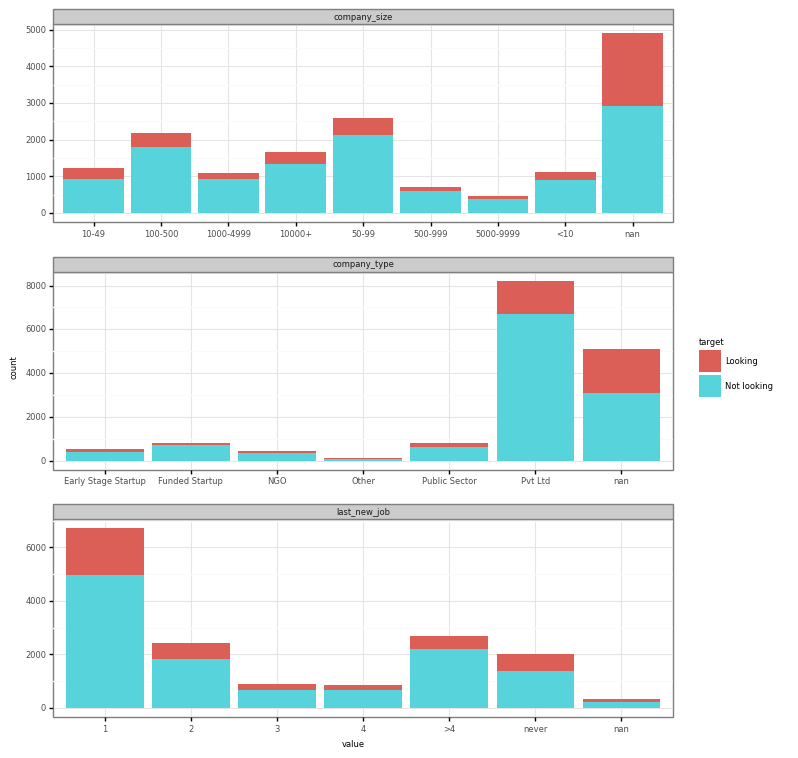

<ggplot: (348072497)>

In [9]:
# plotting the work variables
work_job_long = work_job.melt(id_vars = 'target')
plotnine.options.figure_size = (8, 9)

(
ggplot(data = work_job_long, mapping=aes(x='value', fill='target')) + 
    geom_bar() + 
    facet_wrap(' ~ variable', ncol=1, scales='free', dir='h') + 
    theme_bw() + 
    theme(
        subplots_adjust={'wspace': 0.1, 'hspace': 0.25},
        text = element_text(size = 6)
    )
)

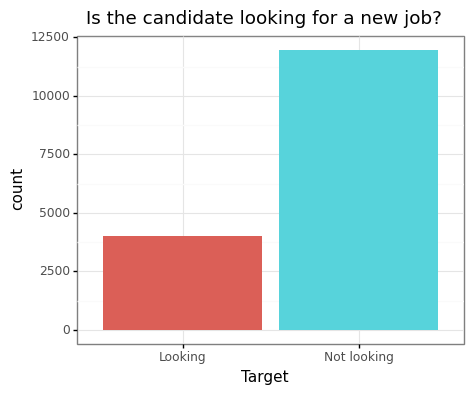

<ggplot: (348000907)>

In [10]:
plotnine.options.figure_size = (5, 4)
(
ggplot(data = job_eda, mapping=aes(x='target', fill = 'target')) + 
    geom_bar() + 
    theme_bw() + 
    labs(x = "Target", title="Is the candidate looking for a new job?") + 
    scale_fill_discrete(guide=False)
)

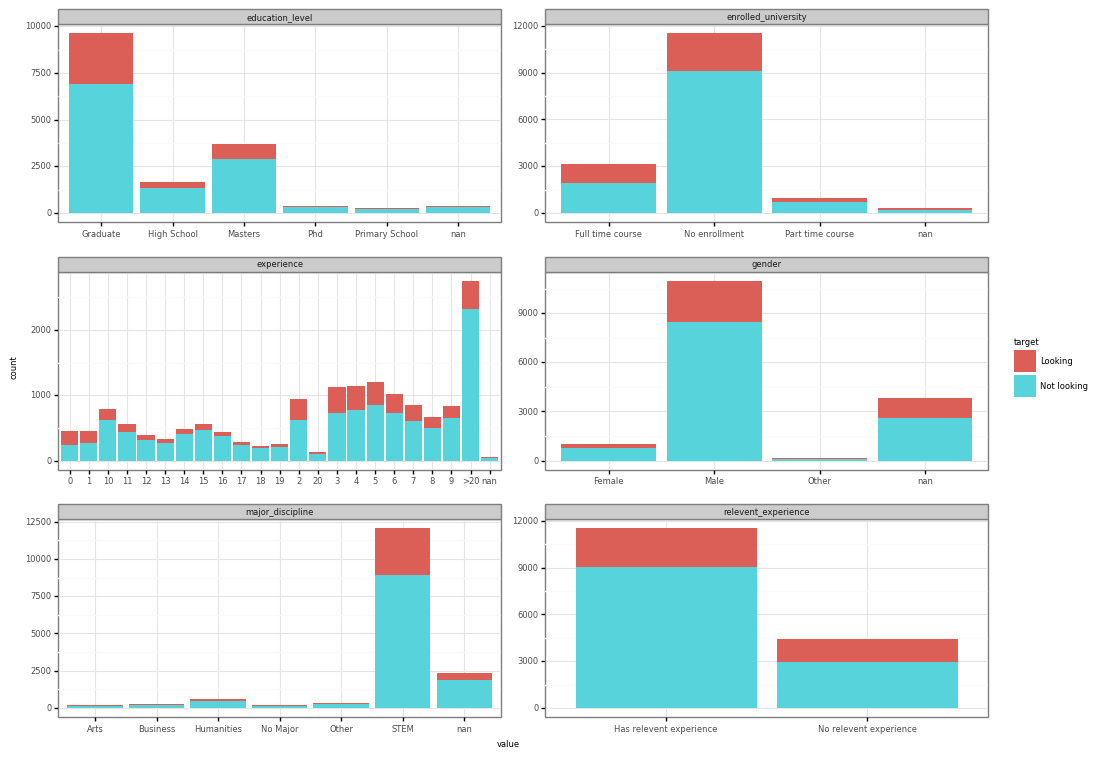

<ggplot: (348207990)>

In [11]:
# plotting the work variables
exp_job_long = exp_job.melt(id_vars = 'target')
plotnine.options.figure_size = (12, 9)

(
ggplot(data = exp_job_long, mapping=aes(x='value', fill='target')) + 
    geom_bar() + 
    facet_wrap(' ~ variable', ncol=2, scales='free', dir='h') + 
    theme_bw() + 
    theme(
        subplots_adjust={'wspace': 0.1, 'hspace': 0.25},
        text = element_text(size = 6)
    )
)

In [12]:
# numeric variables
cont_job_long = cont_job.melt(id_vars = 'target')

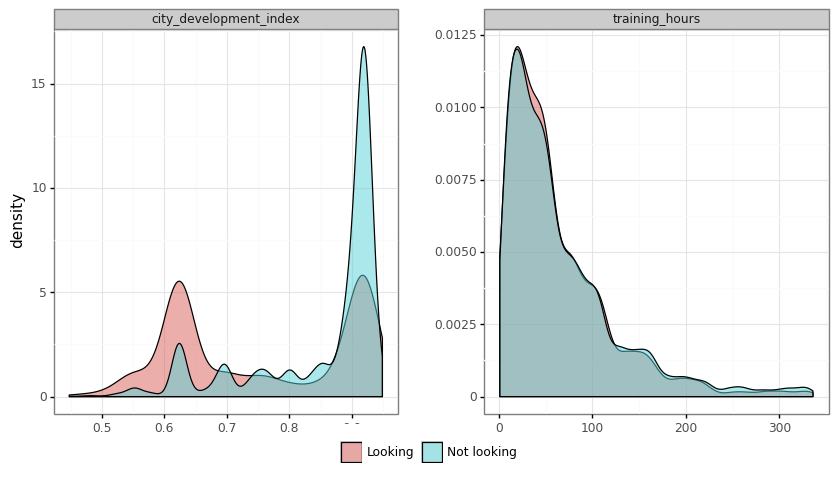

<ggplot: (348351272)>

In [13]:
plotnine.options.figure_size = (10, 5)

(
ggplot(data = cont_job_long, mapping=aes(x='value', fill='target')) + 
#     stat_density(mapping=aes(y = 'stat(count)'), alpha = .5) + 
    geom_density(stat='density', alpha = .5) +
#     geom_histogram(bins = 40) +
    facet_wrap(' ~ variable', ncol=2, scales='free', dir='h') + 
    theme_bw() + 
    theme(subplots_adjust={'wspace': 0.25, 'hspace': 0.25}, 
         legend_position='bottom', 
         axis_title_x=element_blank(), 
         legend_title=element_blank())
)

More enrollees who are not currently working at a company are looking for a job change, as well as those who are enrolled in graduate programs. Missing values for company size, type, and time since the last new job will be assumed to mean that the enrollee doesn't work for a company and hasn't had a job to fill out. It is also reasonable to assume missing values for Major Discipline mean the enrollee did not attend or finish college. Experience will be transformed to numeric ordinal with a cap put at 21 for those with >20 years of experience. The numeric variables show significant skew and different scales and will be transformed for models that require that.

Years since last new job will also be converted to numeric with a cap at 5 as there is not information on those >4 with Never and missing values converted to 0s. 

Missing values for gender will considered a separate value for gender since it is possible the enrollee does not align with a binary gender or the answers to the question did not represent them properly.

Missing values for university enrollment, level of education, experience, major discipline, company size, company type, etc. will be considered as either the lowest ordinal level, its own separate value, a value that could reasonably represent missing data, or 0 appropriately dependent on the type of variable. Based on the variables in this dataset, it is reasonable to assume that missing data is still data and should not be thrown out.

In [14]:
# checking for missing values
job_eda.info()
job_eda.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15965 entries, 18325 to 15795
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city_development_index  15965 non-null  float64
 1   gender                  12172 non-null  object 
 2   relevent_experience     15965 non-null  object 
 3   enrolled_university     15658 non-null  object 
 4   education_level         15574 non-null  object 
 5   major_discipline        13642 non-null  object 
 6   experience              15909 non-null  object 
 7   company_size            11052 non-null  object 
 8   company_type            10887 non-null  object 
 9   last_new_job            15611 non-null  object 
 10  training_hours          15965 non-null  int64  
 11  target                  15965 non-null  object 
dtypes: float64(1), int64(1), object(10)
memory usage: 1.6+ MB


city_development_index       0
gender                    3793
relevent_experience          0
enrolled_university        307
education_level            391
major_discipline          2323
experience                  56
company_size              4913
company_type              5078
last_new_job               354
training_hours               0
target                       0
dtype: int64

In [15]:
# function to clean the data, replacing NAs and fixing other typos
def clean_data(data):
    # fixing typos
    data['enrolled_university'] = data['enrolled_university'].replace("no_enrollment", "No enrollment")
    data['major_discipline'] = data['major_discipline'].replace("Business Degree","Business")
    data['experience'] = data['experience'].replace("<1", "0")
    data['experience'] = data['experience'].replace(">20", "21")
    data['company_size'] = data['company_size'].replace("10/49", "10-49")
    # replacing NAs
    data['city_development_index'] = data['city_development_index'].fillna(np.median)
    data['gender'] = data['gender'].fillna("Unknown")
    data['relevent_experience'] = data['relevent_experience'].fillna('No relevent experience')
    data['enrolled_university'] = data['enrolled_university'].fillna('No enrollment')
    data['education_level'] = data['education_level'].fillna('Less than high school')
    data['major_discipline'] = data['major_discipline'].fillna('No Major')
    data['experience'] = data['experience'].fillna('0')
    data['company_size'] = data['company_size'].fillna('0')
    data['company_type'] = data['company_type'].fillna('None')
    data['last_new_job'] = data['last_new_job'].fillna('never')
    data['training_hours'] = data['training_hours'].fillna(0)
    return(data)

# Data Preprocessing

Here we will create a mapping for the ordinal variables, OneHotEncode the other categorical variables, and scale the all the data after for use in models. We will experiment with scaling and not scaling the ordinal data for algorithms that don't depend on distance based calculations to make predictions.

In [16]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# creating lists of the different sets of variables to be processed and setting up different column
# transformer pipelines

onehot_cols = [
    'gender', 'relevent_experience', 'relevent_experience', 
    'company_type', 'major_discipline'
]

ordinal_cols = [
    'education_level', 'company_size', 'last_new_job'
]

numeric_cols = [
    'city_development_index', 'experience', 'training_hours'
]
# ordered categories fo r
ordinal_categories = [
    ['Less than high school', 'High School', "Primary School", 'Graduate', 'Masters', "Phd"],
    ['0', '<10', '10-49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+'],
    ["never", '1', '2', '3', '4', '>4']
]

# transformer to only scale numeric columns
transform1 = ColumnTransformer(
    [
        ('onehot', OneHotEncoder(), onehot_cols),
        ('ordinal', OrdinalEncoder(categories=ordinal_categories), ordinal_cols),
        ('numeric', StandardScaler(), numeric_cols)
    ]
)

# scaling all columns using OneHotEncoding on all the categorical columns
transform3 = ColumnTransformer(
    [
        ('onehot', OneHotEncoder(), onehot_cols + ordinal_cols),
        ('numeric', StandardScaler(), numeric_cols)
    ]
)

# Model Building and Fitting

Here we will create a function that fits each model we want as a baseline, then optimize them using GridSearchCV, and finally compare predictions on the test dataset against all of the individual models and ensemble of all 3 models.

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


transformers = [transform1, transform3]

X_train_clean = clean_data(X_train.copy())
X_test_clean = clean_data(X_test.copy())
# get baseline using the first transformed dataset

def mod_baseline(X_train, y_train, X_test, y_test, clf, transform, mod_name):
    transformer = transform
    X_train_transformed = transformer.fit_transform(X_train)
    clf.fit(X_train_transformed, y_train)
    # creating predictions
    train_preds = clf.predict(X_train_transformed)
    X_test_transformed = transformer.transform(X_test)
    test_preds = clf.predict(X_test_transformed)
    # calculating and printing accuracies
    train_acc = accuracy_score(y_train, train_preds)
    test_acc = accuracy_score(y_test, test_preds)
    print(mod_name + " Training Accuracy:", train_acc)
    print(mod_name + " Test Accuracy:", test_acc, "\n")
    # return predictions, models, and transformed data
    return(train_preds, test_preds, X_train_transformed, X_test_transformed, clf, transformer)


mods = {
    "KNN": KNeighborsClassifier(metric='manhattan'),
    "Logistic_Regression": LogisticRegression(max_iter=1000),
     "Random_Forest": RandomForestClassifier(n_estimators=30, random_state=42)
}

# checking baseline accuracies from the models to compare to optimized models
# testing different transformers as well
# no significant different to merit using onehotencoding for everying over ordinal
transform_names = ["Ordinal", "OneHotEncoder"]
for name, model in mods.items():
    i=0
    for trans in transformers:
        print(transform_names[i])
        train_preds, test_preds, X_train_transformed, X_test_transformed, mod, transformer = mod_baseline(
            X_train_clean, y_train, X_test_clean, y_test, model, trans, name
        )
        i += 1

print(y_test.value_counts()/len(y_test))

Ordinal
KNN Training Accuracy: 0.8347009082367679
KNN Test Accuracy: 0.7636226982337467 

OneHotEncoder
KNN Training Accuracy: 0.8313811462574382
KNN Test Accuracy: 0.7628711010898158 

Ordinal
Logistic_Regression Training Accuracy: 0.7661133730034451
Logistic_Regression Test Accuracy: 0.7750845546786922 

OneHotEncoder
Logistic_Regression Training Accuracy: 0.7667397431882242
Logistic_Regression Test Accuracy: 0.7758361518226231 

Ordinal
Random_Forest Training Accuracy: 0.9949890385217663
Random_Forest Test Accuracy: 0.7816610296880872 

OneHotEncoder
Random_Forest Training Accuracy: 0.9951143125587222
Random_Forest Test Accuracy: 0.7784667418263811 

0.0    0.746712
1.0    0.253288
Name: target, dtype: float64


The above accuracies are baseline model performances without tuning any parameters. Now we will use GridSearchCV to optimize several model hyperparameters to increase performance.

# Model Optimization

In testing, it appears that onehotencoding the columns does not offer an increase in performance. Moving forwards, only the the ordinal transformer will be used.

In [18]:
transformers = [transform1, transform3]

X_train_clean = clean_data(X_train.copy())
X_test_clean = clean_data(X_test.copy())
# get baseline using the first transformed dataset

def best_model(X_train, y_train, X_test, y_test, clfs, transform, params):
    # initializing some variables to store models and predictions in
    best_mods, train_preds, test_preds = [], [], []
    # transforming the train and test datasets
    transformer = transform
    X_train_transformed = transformer.fit_transform(X_train)
    X_test_transformed = transformer.transform(X_test)
    # looping through the models
    for (name, clf), parms in zip(clfs.items(), params):
        # using GridSearchCV to find the optimal parameters for the data
        grid = GridSearchCV(estimator = clf, param_grid = parms, n_jobs = -1, cv = 5, verbose=True)
        grid.fit(X_train_transformed, y_train)
        best_mod = grid.best_estimator_
        # creating predictions
        train_pred = best_mod.predict(X_train_transformed)
        test_pred = best_mod.predict(X_test_transformed)
        # calculating and printing accuracies
        train_acc = accuracy_score(y_train, train_pred)
        test_acc = accuracy_score(y_test, test_pred)
        print(name + " Training Accuracy:", train_acc)
        print(name + " Test Accuracy:", test_acc, "\n")
        # storing predictions and best CV models
        train_preds.append(train_pred)
        test_preds.append(test_pred)
        best_mods.append(best_mod)
    # return predictions, models, and transformed data
    return(best_mods, transformer, train_preds, test_preds, X_train_transformed, X_test_transformed)

# list of models we want to fit
mods = {
    "Logistic_Regression": LogisticRegression(max_iter=10000, random_state=42, n_jobs=-1, solver='saga'),
    "Random_Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "KNN": KNeighborsClassifier(metric='manhattan', n_jobs=-1)
}

params = [
    {
        'penalty': ['l1', 'l2', 'elasticnet'],
        "C": [0.5, 1.0]        
    },
    {
        "max_depth": [i for i in range(9, 22, 4)],
        "max_features": ['auto', 'sqrt'],
        "n_estimators": [i for i in range(10, 101, 10)],
        'bootstrap': [True, False]
    },
    {
        "n_neighbors": [i for i in range(5, 31, 5)],
        'weights': ['uniform', 'distance'],
        'metric': ['minkowski', 'manhattan']
    }
]

import time
start = time.time()

best_models, transformer, train_preds, test_preds, X_train_transformed, X_test_transformed = best_model(
    X_train_clean, y_train, X_test_clean, y_test, mods, transform1, params
)

end = time.time()
print("Model fitting took:", end - start, "seconds")

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/sawyer/Desktop/data_science_denver/Winter_2021/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.76542437 0.765487          nan 0.76554964 0.76554964        nan]


Logistic_Regression Training Accuracy: 0.7659254619480113
Logistic_Regression Test Accuracy: 0.7747087561067268 

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Random_Forest Training Accuracy: 0.8878797369245224
Random_Forest Test Accuracy: 0.7897406989853438 

Fitting 5 folds for each of 24 candidates, totalling 120 fits
KNN Training Accuracy: 0.7932352020043846
KNN Test Accuracy: 0.7756482525366404 

Model fitting took: 120.14841485023499 seconds


In [19]:
# fitting the voting classifier as the ensemble model
from sklearn.ensemble import VotingClassifier
voting = VotingClassifier([
    ('logistic', best_models[0]),
    ('rf', best_models[1]),
    ('knn', best_models[2])
])

voting.fit(X_train_transformed, y_train)
voting.score(X_train_transformed, y_train)
voting_test_preds = voting.predict(X_test_transformed)
accuracy_score(y_test, voting_test_preds)
best_models.append(voting)

VotingClassifier(estimators=[('logistic',
                              LogisticRegression(max_iter=10000, n_jobs=-1,
                                                 penalty='l1', random_state=42,
                                                 solver='saga')),
                             ('rf',
                              RandomForestClassifier(bootstrap=False,
                                                     max_depth=13,
                                                     n_estimators=60, n_jobs=-1,
                                                     random_state=42)),
                             ('knn',
                              KNeighborsClassifier(n_jobs=-1, n_neighbors=25))])

0.8278108362041967

0.7827884254039834

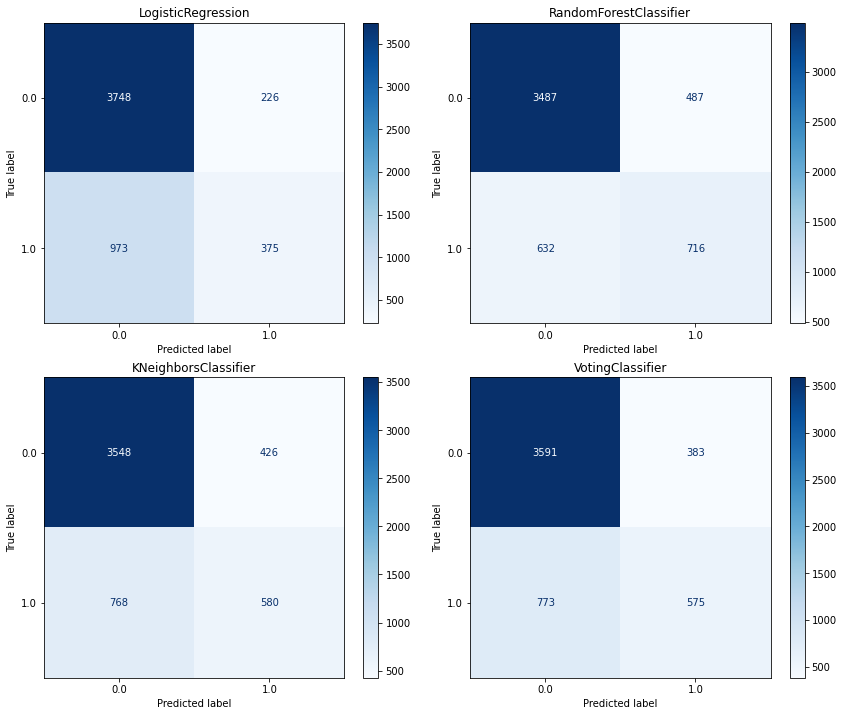

In [20]:
mod_names = [i for i in mods.keys()]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
from sklearn.metrics import plot_confusion_matrix
for mod, ax in zip(best_models, axes.flatten()):
    plot_confusion_matrix(mod, 
                          X_test_transformed, 
                          y_test, 
                          ax=ax, 
                          cmap='Blues')
    ax.title.set_text(type(mod).__name__)
plt.tight_layout();
plt.show();

In [21]:
accs = [mod.score(X_test_transformed, y_test) for mod in best_models]
mod_names = [type(mod).__name__ for mod in best_models]
accuracy_df = pd.DataFrame(zip(mod_names, accs), columns = ['model', "accuracy"])

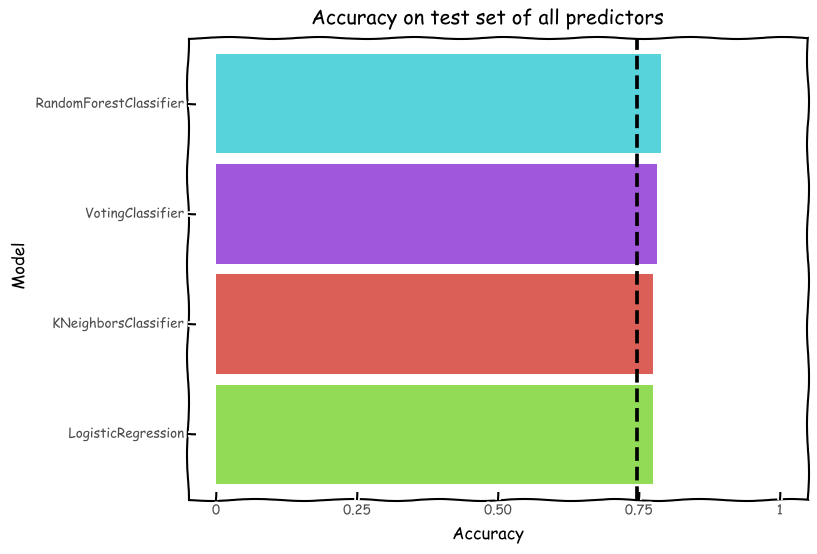

<ggplot: (363663454)>

In [22]:
base_acc = y_test.value_counts()[0]/len(y_test)

accuracy_df = accuracy_df.sort_values(by='accuracy', ascending=True)
# sorting the variable importances for the plot
feature_cat = pd.Categorical(accuracy_df['model'], categories=accuracy_df['model'])

# assign to a new column in the DataFrame
accuracy_df = accuracy_df.assign(feature_cat = feature_cat)
plotnine.options.figure_size = (8, 6)

(
ggplot(data = accuracy_df, mapping = aes(x = 'feature_cat', y = 'accuracy', fill = 'model')) + 
    geom_bar(stat = 'identity') + 
    theme_xkcd() + 
    lims(y = (0, 1)) + 
    scale_fill_discrete(guide=False) +
    labs(x = "Model", y = "Accuracy", title = "Accuracy on test set of all predictors") +
    geom_hline(yintercept = base_acc, size = 1.5, linetype = 'dashed') + 
    coord_flip()
)

In [23]:
for (i, j), k in zip(mods.items(), range(len(mods))):
    print("mod", i, "clf", j, "num", k)

mod Logistic_Regression clf LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42, solver='saga') num 0
mod Random_Forest clf RandomForestClassifier(n_jobs=-1, random_state=42) num 1
mod KNN clf KNeighborsClassifier(metric='manhattan', n_jobs=-1) num 2


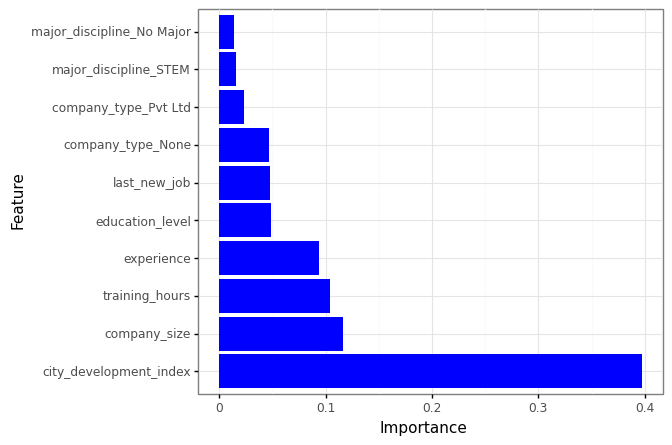

<ggplot: (363690123)>

In [24]:
# top 10 feature importances of the top Random Forest model
rf_features = pd.DataFrame(
    zip(transformer.named_transformers_['onehot'].get_feature_names(onehot_cols).tolist() + ordinal_cols + numeric_cols, 
        best_models[1].feature_importances_), 
    columns = ['feature', 'importance'])
top_10_rf = rf_features.sort_values(by='importance', ascending=False)[:10]

# sorting the variable importances for the plot
feature_cat = pd.Categorical(top_10_rf['feature'], categories=top_10_rf['feature'])

# assign to a new column in the DataFrame
top_10_rf = top_10_rf.assign(feature_cat = feature_cat)

plotnine.options.figure_size = (6, 5)

(
ggplot(data = top_10_rf, mapping=aes(x = 'feature_cat', y = 'importance')) + 
    geom_bar(stat = 'identity', fill='blue') + 
    labs(x = "Feature", y = "Importance") + 
    coord_flip() + 
    theme_bw()
)